<a href="https://colab.research.google.com/github/al438/PROJET_DEEP_CONDUCTEUR/blob/main/KODIA_Projet_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJET: Le conducteur distrait DEEP_LEARNING**<br> 

# **Les bibliothèque** 

In [5]:
!pip install fastai==2.5.3 -q
#!pip uninstall fastai
import fastai
fastai.__version__

'2.5.3'

In [6]:
import pandas as pd
from fastai.vision.all import *
from fastai.metrics import error_rate

# Connecter au drive

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [60]:
path = "drive/MyDrive/DEEP/"
df = pd.read_csv(path + 'driver_imgs_list.csv')



## Question 1 et 2 / Seed 2021, Chargez les images, avec fastai, visualisez un lot (batch)

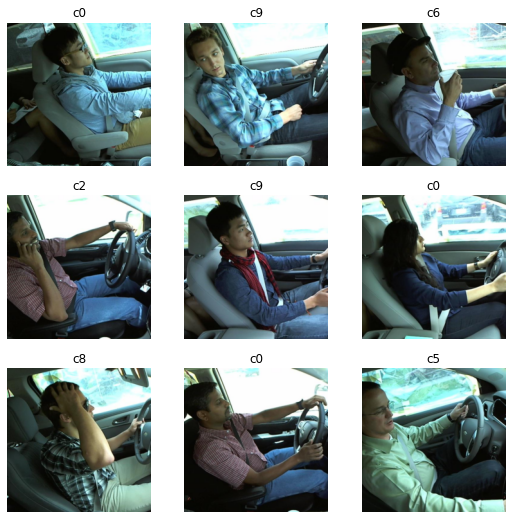

In [61]:
def classe(x):
    return (df.loc[df.img==x, "classname"].values[0])

paths = path+"trainImg"
dls = ImageDataLoaders.from_name_func(
    paths, 
    get_image_files(paths), 
    valid_pct=0.25, 
    seed=2021, 
    label_func=classe, 
    item_tfms=Resize(224))

dls.show_batch()

# Question 3

# Composer les données.

In [62]:
df = df.assign(for_test=False)

# On garde le pourcentage (pourcentage) de sujets par classe
pct = df.assign(nb=1).groupby(['subject', 'classname']).sum()
pct = pct.assign(pct = (pct.nb/df.shape[0]*100))
pct = pct.assign(subject=pct.index.get_level_values('subject'), classname=pct.index.get_level_values('classname'))
pct.index = range(0, pct.shape[0])


# pourcentage de chaque classe dans notre jeu de donnéees
pct_classe = df.classname.value_counts() / df.shape[0] * 100


# on crée un dictionnaire contenant pour chaque classe et pour notre échantillon de test:
#    nb: pourcentage d'individu pour la classe qu'on aura à chaque itération, ,
#    max : correspond à le pourcentage de la classe dans notre jeu de données (dont on ne devra pas trop s'éloigner),
#    subject: sujet sélectionné pour la classe.
dico = dict()
for c in df.classname.unique():
    dico[c] = { 'nb': 0, 'max': pct_classe[c], 'subject': [] }
dico['t'] = { 'nb': 0, 'max': 25, 'subject': [] }


for c in df.classname.unique():
    # Les instruction à l'intérieur de cette boucle permettront de déterminer si le sujet sera pris en test ou pas
    for sub in pct.subject.unique():
        # la condition ci-dessous permet de vérifier pour notre échantillon de test si nous sommes en dessous des 25%,
        # et que pour chaque classe nousavons le pourcentage qui est respecté dans le test.
        if sub not in dico['t']['subject'] and dico['t']['nb'] < 25 and sub not in dico[c]['subject'] and dico[c]['nb'] < dico[c]['max']:
            # cette boucle permet d'ajouter le sujet dans la partie subject de chaque classe vu que le sujet respecte les conditions précédentes
            for c2 in df.classname.unique():
                dico[c2]['subject'].append(sub)
                dico[c2]['nb'] += sum(pct.loc[((pct.subject == sub) & (pct.classname == c2)), 'pct'])
           
            # on ajoute le sujet à la partie sujet de notre partie test
            dico['t']['subject'].append(sub)
            dico['t']['nb'] += sum(pct.loc[pct.subject == sub, 'pct'])


df.loc[df.subject.isin(dico['t']['subject']), 'for_test'] = True

In [63]:
df.loc[:, "path"] = df.loc[:, "classname"].astype("str") + '/' + df.loc[:, "img"].astype("str")

In [64]:
categories = {
"c0": "safe driving",
"c1": "texting - right",
"c2": "talking on the phone - right",
"c3": "texting - left",
"c4": "talking on the phone - left",
"c5": "operating the radio",
"c6": "drinking",
"c7": "reaching behind",
"c8": "hair and makeup",
"c9": "talking to passenger"
}

def label_name(df):
    if df['classname'] =='c0':
        return "safe driving"
    elif df['classname'] =='c1':
        return "texting - right"
    elif df['classname'] =='c2':
        return "talking on the phone - right"
    elif df['classname'] == 'c3':
        return "texting - left"
    elif df['classname'] =='c4':
        return "talking on the phone - left"
    elif df['classname'] =='c5':
        return "operating the radio"
    elif df['classname'] =='c6':
        return "drinking"
    elif df['classname'] =='c7':
        return "reaching behind"
    elif df['classname'] == 'c8':
        return "hair and makeup"
    elif df['classname'] == 'c9':
        return "talking to passenger"
    else :
        return "other"

df['labelName'] = df.apply(label_name, axis=1)

In [65]:
dls = ImageDataLoaders.from_df(df,
                                path=path,
                                folder='train',
                                fn_col=4,
                                label_col=5,
                                valid_col='for_test',
                                seed=2021,
                                item_tfms=Resize(224),
                                bs=16)

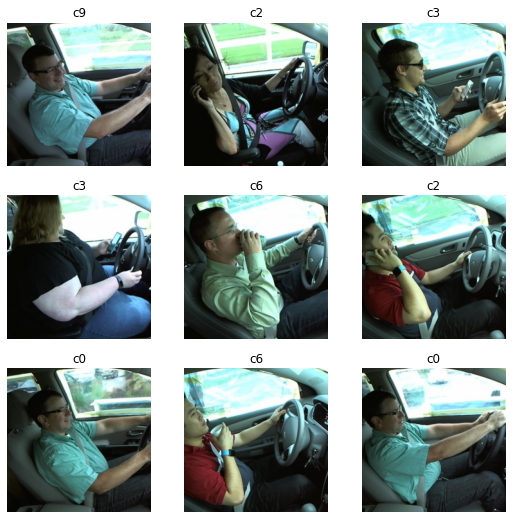

In [66]:
dls.show_batch()

# Question 4 / Entraînez votre modèle pendant 5 époques.

In [67]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

In [68]:
learn.fine_tune(epochs=5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.867487,1.071684,0.348135,0.651865,00:33


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.136266,0.467181,0.145648,0.854352,00:33
1,0.681343,0.216773,0.069272,0.930728,00:31
2,0.409383,0.163928,0.046181,0.953819,00:31
3,0.254953,0.141461,0.044405,0.955595,00:31
4,0.169410,0.138547,0.040853,0.959147,00:31


# Question 5/ Entraînez votre modèle à nouveau jusqu’à la dégradation (forte augmentation) du loss.

In [70]:
learn.fine_tune(epochs=30)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.064338,0.136332,0.044405,0.955595,00:30


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.051469,0.120952,0.039076,0.960924,00:31
1,0.042440,0.120059,0.037300,0.962700,00:30
2,0.034517,0.129102,0.039076,0.960924,00:32
3,0.027575,0.128692,0.030195,0.969805,00:39
4,0.023823,0.153562,0.033748,0.966252,00:31
5,0.024609,0.152992,0.039076,0.960924,00:31
6,0.029435,0.184384,0.046181,0.953819,00:31
7,0.031570,0.202863,0.042629,0.957371,00:31
8,0.030690,0.203783,0.035524,0.964476,00:32
9,0.029936,0.178750,0.028419,0.971581,00:31


# Question 6 / Entraînez de nouveau votre modèle en effectuant des changements de sorte à améliorer la performance du modèle.

In [71]:
learn2 = cnn_learner(dls, resnet101 , metrics=[error_rate, accuracy])


In [72]:
learn2.fine_tune(epochs=7)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.209289,0.865596,0.232682,0.767318,01:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.594839,0.272605,0.090586,0.909414,01:15
1,0.330314,0.216500,0.069272,0.930728,01:15
2,0.204360,0.216192,0.049734,0.950266,01:15
3,0.129787,0.177643,0.044405,0.955595,01:15
4,0.089532,0.142979,0.037300,0.962700,01:15
5,0.059036,0.121810,0.031972,0.968028,01:15
6,0.037695,0.115076,0.028419,0.971581,01:15


# Question 7 / Présentez les résultats de votre modèle

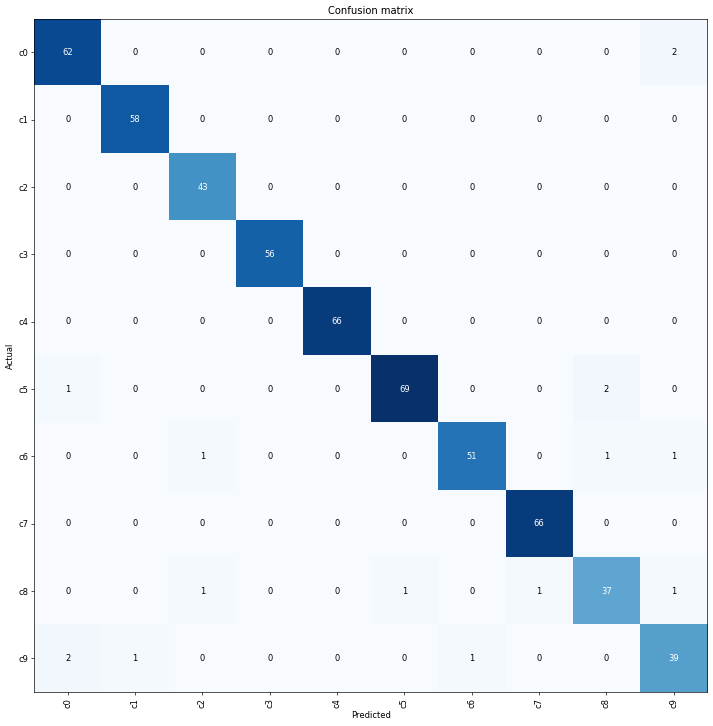

In [73]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [74]:
interp.print_classification_report()

              precision    recall  f1-score   support

          c0       0.95      0.97      0.96        64
          c1       0.98      1.00      0.99        58
          c2       0.96      1.00      0.98        43
          c3       1.00      1.00      1.00        56
          c4       1.00      1.00      1.00        66
          c5       0.99      0.96      0.97        72
          c6       0.98      0.94      0.96        54
          c7       0.99      1.00      0.99        66
          c8       0.93      0.90      0.91        41
          c9       0.91      0.91      0.91        43

    accuracy                           0.97       563
   macro avg       0.97      0.97      0.97       563
weighted avg       0.97      0.97      0.97       563



# Question 8/ interp.most_confused(min_val=50)

In [75]:
interp.most_confused(min_val=50)

[]